In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ds1 = pd.read_csv('data/Dataset 1_EV charging reports.csv', sep=';', decimal=',')

ds2 = pd.read_csv('data/Dataset 2_Hourly EV loads - Per user.csv', sep=';', decimal=',')

ds3a = pd.read_csv('data/Dataset 3a_Hourly EV loads - Aggregated private.csv', sep=';', decimal=',')

ds3b = pd.read_csv('data/Dataset 3b_Hourly EV loads - Aggregated shared.csv', sep=';', decimal=',')

ds5 = pd.read_csv('data/Dataset 5_AMS data from garage Bl2.csv', sep=';', decimal=',')

ds6 = pd.read_csv('data/Dataset 6_Local traffic distribution.csv', sep=';', decimal=',')

In [5]:
ds1_clean = ds1.dropna(subset=['End_plugout','Start_plugin']).copy() 


ds1['Start_plugin'] = pd.to_datetime(ds1_clean['Start_plugin'], format='%d.%m.%Y %H:%M') #format the string to a datetime object
ds1['End_plugout'] = pd.to_datetime(ds1_clean['End_plugout'], format='%d.%m.%Y %H:%M')

ds1_clean = ds1_clean[ds1_clean['El_kWh'] > 0] #if no energy was charged the row should be dropped

type(ds1['End_plugout'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [7]:
ds1_clean['min_needed_hours_11kW'] = ds1_clean['El_kWh'] / 11


ds1_clean['recorded_duration_hours'] = ds1_clean['End_plugout'] - ds1_clean['Start_plugin']
ds1_clean['recorded_duration_hours'] = ds1_clean['recorded_duration_hours'].dt.total_seconds() / 3600

impossible_duration_index = ds1_clean['recorded_duration_hours'] < ds1_clean['min_needed_hours_11kW']

ds1_clean.loc[impossible_duration_index, 'End_plugout'] = pd.NaT

ds1_clean.dropna(subset=['End_plugout'], inplace=True)

In [8]:
ds1_clean_shared = ds1_clean.dropna(subset=['Shared_ID']) #filter the dataset to only include shared charging sessions

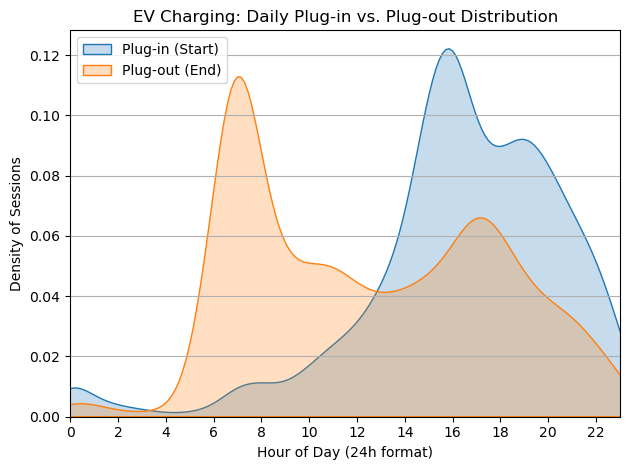

In [9]:

#get the plugin and plugout times
plugin_hour = ds1['Start_plugin'].dt.hour 
plugout_hour = ds1['End_plugout'].dt.hour


# plugin distribution
sns.kdeplot(plugin_hour, fill=True, label='Plug-in (Start)')

# plugout distribution
sns.kdeplot(plugout_hour, fill=True, label='Plug-out (End)')




# Formatting
plt.title('EV Charging: Daily Plug-in vs. Plug-out Distribution')
plt.xlabel('Hour of Day (24h format)')
plt.ylabel('Density of Sessions')
plt.xticks(range(0, 25, 2)) 
plt.xlim(0, 23)
plt.grid(axis='y')
plt.legend()

plt.tight_layout()
plt.show()

Plug-outs peak in the morning around the begining of the work day, while plugins peak after work hours end

In [88]:
charger_power = 3.6

ds1_clean['Synthetic_charge_time_hrs'] = ds1_clean['El_kWh'] / charger_power

ds1_clean['Idle_time_hrs'] = ds1_clean['recorded_duration_hours'] - ds1_clean['Synthetic_charge_time_hrs']



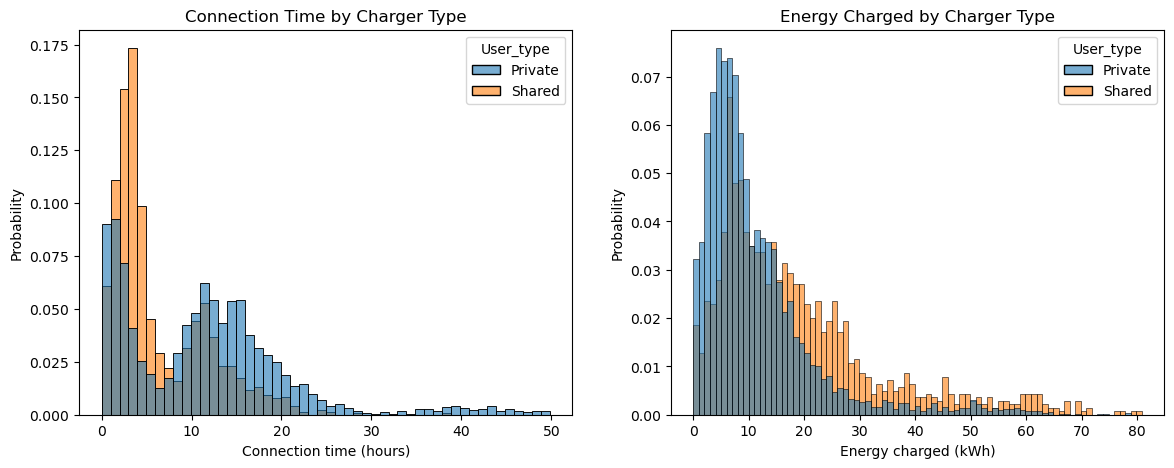

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Connection Time Histogram axes[0]
sns.histplot(data=ds1_clean[ds1_clean['Duration_hours'] <= 50], x='Duration_hours', hue='User_type', binwidth=1, stat='probability', common_norm=False, ax=axes[0], alpha=0.6)
axes[0].set_title('Connection Time by Charger Type')
axes[0].set_xlabel('Connection time (hours)')

# Plot 2: Energy Charged Histogram axes[1]
sns.histplot(data=ds1_clean[ds1_clean['El_kWh'] <= 100], 
             x='El_kWh', hue='User_type', binwidth=1, 
             stat='probability', common_norm=False, ax=axes[1], alpha=0.6)
axes[1].set_title('Energy Charged by Charger Type')
axes[1].set_xlabel('Energy charged (kWh)')

plt.show()

In [11]:
ds1_weekends = ds1_clean[ds1_clean['weekdays_plugin'].isin(['Saturday', 'Sunday'])]
ds1_weekdays = ds1_clean[~ds1_clean['weekdays_plugin'].isin(['Saturday', 'Sunday'])]


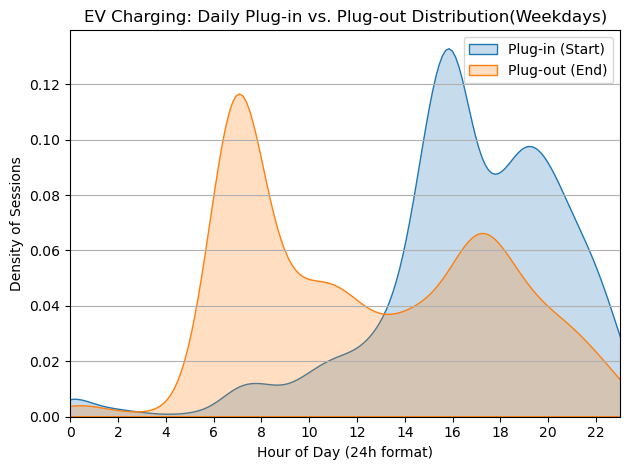

In [13]:
plugin_hour_wd = ds1_weekdays['Start_plugin'].dt.hour 
plugout_hour_wd = ds1_weekdays['End_plugout'].dt.hour


# plugin distribution
sns.kdeplot(plugin_hour_wd, fill=True, label='Plug-in (Start)')

# plugout distribution
sns.kdeplot(plugout_hour_wd, fill=True, label='Plug-out (End)')




# Formatting
plt.title('EV Charging: Daily Plug-in vs. Plug-out Distribution(Weekdays)')
plt.xlabel('Hour of Day (24h format)')
plt.ylabel('Density of Sessions')
plt.xticks(range(0, 25, 2)) 
plt.xlim(0, 23)
plt.grid(axis='y')
plt.legend()

plt.tight_layout()
plt.show()

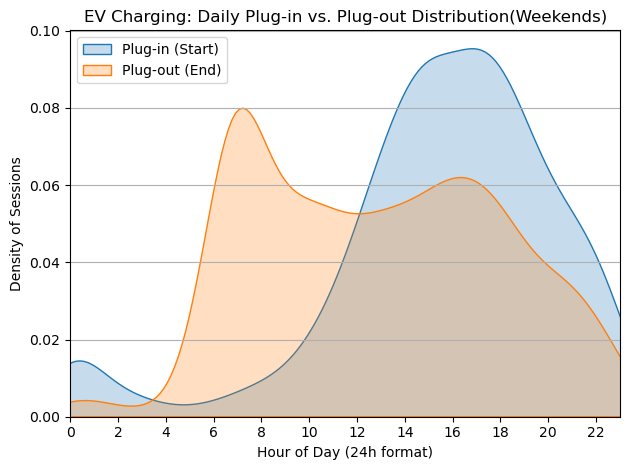

In [15]:
plugin_hour_we = ds1_weekends['Start_plugin'].dt.hour 
plugout_hour_we = ds1_weekends['End_plugout'].dt.hour


# plugin distribution
sns.kdeplot(plugin_hour_we, fill=True, label='Plug-in (Start)')

# plugout distribution
sns.kdeplot(plugout_hour_we, fill=True, label='Plug-out (End)')




# Formatting
plt.title('EV Charging: Daily Plug-in vs. Plug-out Distribution(Weekends)')
plt.xlabel('Hour of Day (24h format)')
plt.ylabel('Density of Sessions')
plt.xticks(range(0, 25, 2)) 
plt.xlim(0, 23)
plt.grid(axis='y')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
import statsmodels.api as sm

In [39]:
ds6['Date_from'] = pd.to_datetime(ds6['Date_from'], format='%d.%m.%Y %H:%M')


#Clean the data by replacing '-' with '0' and converting to int
ds6['KROPPAN BRU'] = np.where(ds6['KROPPAN BRU'].isin(['-']), '0', ds6['KROPPAN BRU'])
ds6['KROPPAN BRU'] = ds6['KROPPAN BRU'].str.replace(',', '.').astype(int)

ds6['MOHOLTLIA'] = np.where(ds6['MOHOLTLIA'].isin(['-']), '0', ds6['MOHOLTLIA'])
ds6['MOHOLTLIA'] = ds6['MOHOLTLIA'].str.replace(',', '.').astype(int)

#ds6['MOHOLT RAMPE 2'] = ds6['MOHOLT RAMPE 2'].str.replace(',', '.').astype(int)

#ds6['Jonsvannsveien vest for Steinanvegen'] = ds6['Jonsvannsveien vest for Steinanvegen'].str.replace(',', '.').astype(int)

ds6['SELSBAKK'] = np.where(ds6['SELSBAKK'].isin(['-']), '0', ds6['SELSBAKK'])
ds6['SELSBAKK'] = ds6['SELSBAKK'].str.replace(',', '.').astype(int)

display(type(ds6['Jonsvannsveien vest for Steinanvegen'][0]), type(ds6['MOHOLT RAMPE 2'][0]), type(ds6['MOHOLTLIA'][0]), type(ds6['KROPPAN BRU'][0]), type(ds6['SELSBAKK'][0]))


numpy.int64

numpy.int64

numpy.int64

numpy.int64

numpy.int64

In [40]:
ds6['Average_Small_Cars'] = ds6.iloc[:, 2:7].mean(axis=1)


In [57]:
#testing/debugging for CCF

ev_counts = ds1_private.groupby('Hour_Floor').size().to_frame(name='Plug_ins')
ev_counts.index.name = 'Date_from'


ccf_df = ds6[['Average_Small_Cars']]



In [54]:
ds1_private = ds1_clean[ds1_clean['User_type'] == 'Private'].copy()


ds1_private['Hour_Floor'] = ds1_private['Start_plugin'].dt.floor('h')

ev_counts = ds1_private.groupby('Hour_Floor').size().to_frame(name='Plug_ins')
ev_counts.index.name = 'Date_from'

ccf_df = ds6[['Average_Small_Cars']]
ccf_df['Plug_ins'] = ev_counts['Plug_ins'].fillna(0)

ccf_results = sm.tsa.stattools.ccf(ccf_df['Plug_ins'], ccf_df['Average_Small_Cars'], adjusted=False)

/var/folders/pf/1cgnzwt530v3b86wl4x2223h0000gn/T/ipykernel_30337/171298419.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccf_df['Plug_ins'] = ev_counts['Plug_ins'].fillna(0)
/opt/anaconda3/lib/python3.12/site-packages/scipy/signal/_signaltools.py:243: RuntimeWarning: Use of fft convolution on input with NAN or inf results in NAN or inf output. Consider using method='direct' instead.
  return convolve(in1, _reverse_and_conj(in2), mode, method)


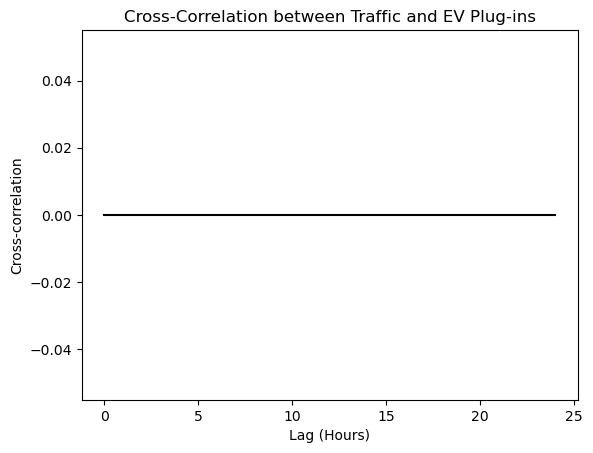

TypeError: unsupported format string passed to numpy.ndarray.__format__

In [45]:
plt.stem(range(25), ccf_results[:25], basefmt="k-")

plt.title('Cross-Correlation between Traffic and EV Plug-ins')
plt.xlabel('Lag (Hours)')
plt.ylabel('Cross-correlation')

plt.show()

print(f"Lag 0 correlation: {ccf_results:.3f}")
print(f"Lag 1 correlation: {ccf_results[5]:.3f}")

